Predicción de la eficiencia de combustible usando regresión con Early Stopping : 40:00 min
===

* Última modificación: Ago 2, 2021 | [YouTube](https://youtu.be/Z3q1a3Dq0UI)

Adaptado de https://www.tensorflow.org/tutorials/keras/regression

## Importación de librerías

In [1]:
πimport warnings

warnings.filterwarnings("ignore")

In [2]:
import logging

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

#
# Precisión en pantalla de NumPy
#
np.set_printoptions(precision=3, suppress=True)

#
# Establece el nivel de reporte en
# pantalla de TensorFlow
#
logger = tf.get_logger().setLevel(logging.ERROR)

print(tf.__version__)

2.5.0


## Carga y configuración del dataset

In [3]:
url = "https://raw.githubusercontent.com/jdvelasq/datalabs/master/datasets/auto-mpg.csv"

raw_dataset = pd.read_csv(
    url,
    na_values='?',
    sep=",",
)

raw_dataset.pop('car name')

dataset = raw_dataset.copy()
dataset.tail()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin
393,27.0,4,140.0,86.0,2790,15.6,82,1
394,44.0,4,97.0,52.0,2130,24.6,82,2
395,32.0,4,135.0,84.0,2295,11.6,82,1
396,28.0,4,120.0,79.0,2625,18.6,82,1
397,31.0,4,119.0,82.0,2720,19.4,82,1


In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    392 non-null    float64
 4   weight        398 non-null    int64  
 5   acceleration  398 non-null    float64
 6   model year    398 non-null    int64  
 7   origin        398 non-null    int64  
dtypes: float64(4), int64(4)
memory usage: 25.0 KB


## Exploración del dataset

In [5]:
#
# Datos NA
#
dataset.isna().sum()

mpg             0
cylinders       0
displacement    0
horsepower      6
weight          0
acceleration    0
model year      0
origin          0
dtype: int64

In [6]:
#
# Se borran las filas NA
#
dataset = dataset.dropna()

In [7]:
#
# One-hot encoding
#
dataset["origin"] = dataset.origin.map(
    {
        1: "USA",
        2: "Europe",
        3: "Japan",
    }
)

dataset.tail()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin
393,27.0,4,140.0,86.0,2790,15.6,82,USA
394,44.0,4,97.0,52.0,2130,24.6,82,Europe
395,32.0,4,135.0,84.0,2295,11.6,82,USA
396,28.0,4,120.0,79.0,2625,18.6,82,USA
397,31.0,4,119.0,82.0,2720,19.4,82,USA


In [8]:
#
# Genera variables dummy para las columnas alfanuméricas.
# Note que la columna Origin se remueve del dataset
#
dataset = pd.get_dummies(
    dataset,
    columns=["origin"],
    prefix="",
    prefix_sep="",
)
dataset.tail()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720,19.4,82,0,0,1


## Conjuntos de entrenamiento y prueba

In [9]:
#
# El uso de esta función es más simple que el uso de
# train_test_split
#
train_dataset = dataset.sample(
    frac=0.8,
    random_state=0,
)

test_dataset = dataset.drop(train_dataset.index)

## Inspección de los datos

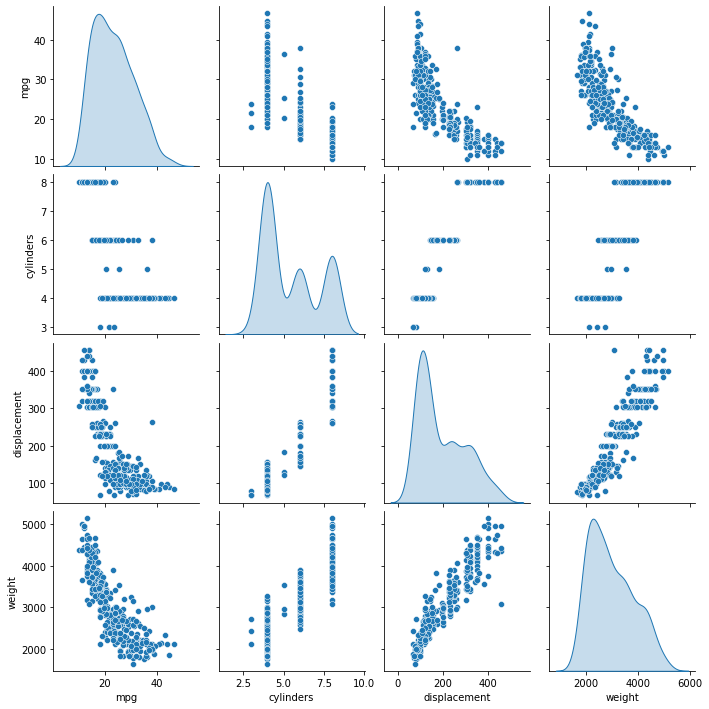

In [10]:
sns.pairplot(
    train_dataset[
        [
            "mpg",
            "cylinders",
            "displacement",
            "weight",
        ]
    ],
    diag_kind="kde",
)

In [11]:
#
# Estadísticos
#
train_stats = train_dataset.describe()
train_stats.pop("mpg")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
model year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0


In [12]:
#
# Extracción de la variable dependiente
#
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_dataset.pop('mpg')
test_labels = test_dataset.pop('mpg')

## Normalización de los datos

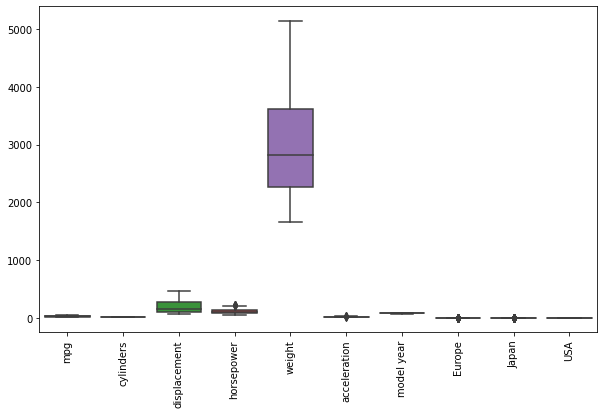

In [13]:
#
# Los rangos de las variables numéricas son
# bastantes diferentes
#
plt.figure(figsize=(10, 6))
sns.boxplot(data=train_features)
plt.xticks(rotation=90);

In [14]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
cylinders,5.477707,1.699788
displacement,195.318471,104.331589
horsepower,104.869427,38.096214
weight,2990.251592,843.898596
acceleration,15.559236,2.789230
model year,75.898089,3.675642
Europe,0.178344,0.383413
Japan,0.197452,0.398712
USA,0.624204,0.485101


In [15]:
#
# Crea una capa para proprocesar los datos
#
normalizer = preprocessing.Normalization()

#
# Entrena (adapta) el modelo
#
normalizer.adapt(np.array(train_features))

#
normalizer.mean.numpy()

array([  23.311,    5.478,  195.318,  104.869, 2990.252,   15.559,
         75.898,    0.178,    0.197,    0.624], dtype=float32)

In [16]:
np.sqrt(normalizer.variance.numpy())

array([  7.716,   1.697, 104.165,  38.035, 842.554,   2.785,   3.67 ,
         0.383,   0.398,   0.484], dtype=float32)

## Regresión lineal con una sola variable

In [17]:
#
# Se copian los valores de la columna horsepower
#
horsepower = np.array(train_features["horsepower"])

#
# Se crea un normalizador que recibe una sola entrada
#
horsepower_normalizer = preprocessing.Normalization(
    input_shape=[
        1,
    ],
)

#
# Entrena el normalizador
#
horsepower_normalizer.adapt(horsepower)

In [18]:
#
# Crea una red neuronal de una sola capa con 
# neurona de salida y activación lineal
# g(x) = x
#
horsepower_model = tf.keras.Sequential([
    horsepower_normalizer,
    layers.Dense(units=1)
])

horsepower_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense (Dense)                (None, 1)                 2         
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


In [19]:
#
# El modelo aun no ha sido entrenado, pero tiene
# pesos aleaotrios en las conexiones. Se pronostican
# los primeros 10 valores 
#
horsepower_model.predict(horsepower[:10])

array([[ 1.332],
       [ 0.752],
       [-2.459],
       [ 1.868],
       [ 1.689],
       [ 0.663],
       [ 2.001],
       [ 1.689],
       [ 0.44 ],
       [ 0.752]], dtype=float32)

In [20]:
#
# Pesos iniciales de las conexiones
#
for v in horsepower_model.trainable_weights:
    print(v.numpy())
    print()

[[-1.697]]

[0.]



In [21]:
#
# Los pesos de las conexiones también pueden
# verse a traves de la propiedad weights
#
for v in horsepower_model.layers[1].weights:
    print(v.numpy())

[[-1.697]]
[0.]


In [22]:
#
# Compila el modelo
#
horsepower_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss="mean_absolute_error",
)

In [23]:
#
# Entrena el modelo
#
history = horsepower_model.fit(
    train_features["horsepower"],
    train_labels,
    epochs=100,
    verbose=0,
    #
    # Separa el 20% de los datos de entrenamiento
    # para validación
    #
    validation_split=0.2,
)


hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,3.804486,4.176386,95
96,3.807494,4.202797,96
97,3.804079,4.180317,97
98,3.803929,4.192608,98
99,3.803924,4.195870,99


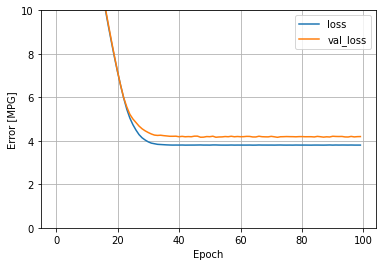

In [24]:
def plot_loss(history):
    
    plt.plot(history.history["loss"], label="loss")
    plt.plot(history.history["val_loss"], label="val_loss")
    plt.ylim([0, 10])
    plt.xlabel("Epoch")
    plt.ylabel("Error [MPG]")
    plt.legend()
    plt.grid(True)


plot_loss(history)

In [25]:
test_results = {}

test_results["horsepower_model"] = horsepower_model.evaluate(
    test_features["horsepower"],
    test_labels,
    verbose=0,
)

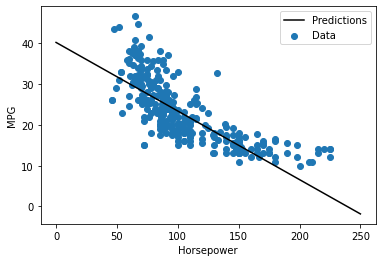

In [26]:
def plot_horsepower(x, y):
    
    plt.scatter(
        train_features["horsepower"],
        train_labels,
        label="Data",
    )
    plt.plot(x, y, color="k", label="Predictions")
    plt.xlabel("Horsepower")
    plt.ylabel("MPG")
    plt.legend()


x = tf.linspace(0.0, 250, 251)
y = horsepower_model.predict(x)
plot_horsepower(x, y)

## Regresión lineal con varias variables

In [27]:
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

linear_model.predict(train_features[:10])

array([[ 0.762],
       [ 2.35 ],
       [-1.49 ],
       [ 2.296],
       [ 0.34 ],
       [ 1.285],
       [ 0.605],
       [ 2.965],
       [ 0.547],
       [-0.856]], dtype=float32)

In [28]:
linear_model.layers[1].kernel

<tf.Variable 'dense_1/kernel:0' shape=(10, 1) dtype=float32, numpy=
array([[ 0.187],
       [-0.529],
       [-0.465],
       [-0.262],
       [ 0.612],
       [ 0.715],
       [ 0.562],
       [-0.148],
       [-0.615],
       [ 0.422]], dtype=float32)>

In [29]:
linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [30]:
history = linear_model.fit(
    train_features,
    train_labels,
    epochs=100,
    verbose=0,
    validation_split=0.2,
)

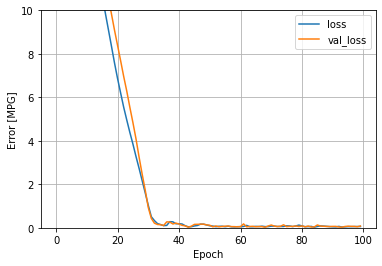

In [31]:
plot_loss(history)

In [32]:
test_results["linear_model"] = linear_model.evaluate(
    test_features,
    test_labels,
    verbose=0,
)

## Red neuronal con una sola variable

In [33]:
def build_and_compile_model(norm):
    
    model = keras.Sequential(
        [
            norm,
            layers.Dense(64, activation="relu"),
            layers.Dense(64, activation="relu"),
            layers.Dense(1),
        ]
    )

    model.compile(
        loss="mean_absolute_error",
        optimizer=tf.keras.optimizers.Adam(0.001),
    )
    return model


dnn_horsepower_model = build_and_compile_model(horsepower_normalizer)
dnn_horsepower_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                128       
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 4,356
Trainable params: 4,353
Non-trainable params: 3
_________________________________________________________________


In [34]:
history = dnn_horsepower_model.fit(
    train_features["horsepower"],
    train_labels,
    validation_split=0.2,
    verbose=0,
    epochs=100,
)

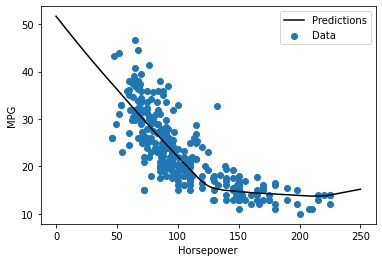

In [35]:
x = tf.linspace(0.0, 250, 251)
y = dnn_horsepower_model.predict(x)
plot_horsepower(x, y)

In [36]:
test_results["dnn_horsepower_model"] = dnn_horsepower_model.evaluate(
    test_features["horsepower"],
    test_labels,
    verbose=0,
)

## Red neuronal con todas las variables

In [37]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 10)                21        
_________________________________________________________________
dense_5 (Dense)              (None, 64)                704       
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 4,950
Trainable params: 4,929
Non-trainable params: 21
_________________________________________________________________


In [38]:
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0,
    epochs=100,
)

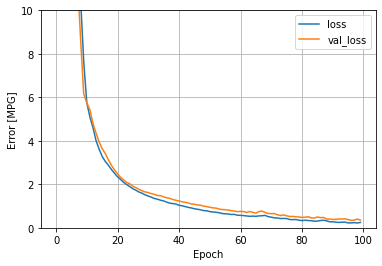

In [39]:
plot_loss(history)

In [40]:
test_results["dnn_model"] = dnn_model.evaluate(
    test_features,
    test_labels,
    verbose=0,
)

## Desempeño del modelo

In [41]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
horsepower_model,3.648265
linear_model,0.073984
dnn_horsepower_model,2.924088
dnn_model,0.298709


## Pronostico

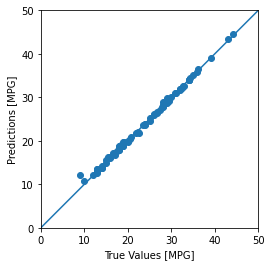

In [42]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

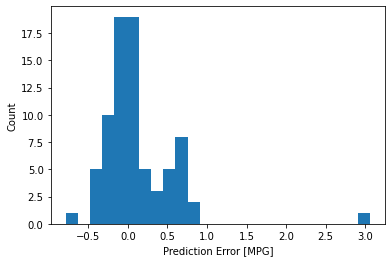

In [43]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [MPG]')
_ = plt.ylabel('Count')

## Almacenamiento y recuperación del modelo en disco

In [44]:
dnn_model.save("dnn_model")

reloaded = tf.keras.models.load_model("dnn_model")

test_results["reloaded"] = reloaded.evaluate(
    test_features,
    test_labels,
    verbose=0,
)

reloaded = tf.keras.models.load_model("dnn_model")

test_results["reloaded"] = reloaded.evaluate(
    test_features,
    test_labels,
    verbose=0,
)

pd.DataFrame(test_results, index=["Mean absolute error [MPG]"]).T

,Mean absolute error [MPG]
horsepower_model,3.648265
linear_model,0.073984
dnn_horsepower_model,2.924088
dnn_model,0.298709
reloaded,0.298709


In [49]:
# Limpieza del disco duro
!rm -r -f dnn_model